In [1]:
from google.colab import drive
drive.mount("/content/gdrive/")

Mounted at /content/gdrive/


In [ ]:
# Load thư viện cần thiết
import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model, Model
from tensorflow.keras import Input
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

import numpy as np
import cv2
import os

### Giải nén dataset

In [2]:
zip_path = '/content/gdrive/MyDrive/Teaching Assistant Saturday/My code/week 5/Minh/cifar10/cifar10.zip'
!cp "{zip_path}" .
!unzip -q cifar10.zip
!rm cifar10.zip

### Đường dẫn các tập train, val, test

In [ ]:
train_path = "/content/cifar10/train"
val_path = "/content/cifar10/val"
test_path = "/content/cifar10/test"

### Show thử các ảnh trong các tập

In [ ]:
def show_image(dataset_path):
  image_list = []
  for folder in os.listdir(dataset_path):
    image_path = os.path.join(os.path.join(dataset_path, folder), os.listdir(os.path.join(dataset_path, folder))[0])
    """
    Chuyển ảnh sang dạng RGB
    image = cv2.imread(image_path), folder
    image = cv2.cvtColor(image, cv2.BGR2RGB)
    image_list.append(image)

    """
    # Opencv2 đọc ảnh ở dạng BGR
    image_list.append([cv2.imread(image_path), folder])
  
  plt.subplots(figsize = (10, 10))
  for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image_list[i][0])
    plt.xlabel(image_list[i][1])
  plt.show()

#### Train

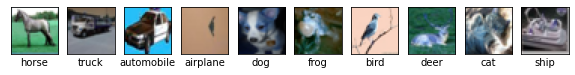

In [ ]:
show_image(train_path)

#### Validation

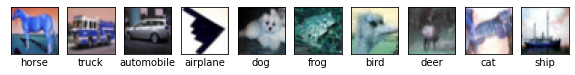

In [ ]:
show_image(val_path)

#### Test

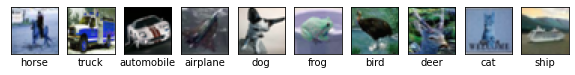

In [ ]:
show_image(test_path)

### Augment data

In [ ]:
# hàm chuẩn hóa luôn chạy cuối cùng 
# Số lượng ảnh bộ dữ liệu gốc không thay đổi tức là mình cho 500 ảnh vào augment thì đầu ra vẫn là 500
train_datagen = ImageDataGenerator(
    # Tăng giảm độ sáng lấy ngẫu nhiên trong khoảng 0.5 đến 1.5
    brightness_range = [0.5, 1.5],
    # Dịch ảnh theo chiều rộng
    # Với giá trị <= 1 ví dụ ảnh mình có chiều rộng 100 px dùng 0.2 tức là dịch ngẫu nhiên ảnh (-20, 20)
    # Với giá trị > 1 thì ví dụ điền số 2 thì nó [-1, 0, 1]
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    # Lật ngược ảnh 
    horizontal_flip = True,
    # Phóng to [0.7, 1.2] chọn 1 số trong khoảng [0.7, 1.2]
    zoom_range = [0.7, 1.2],
    # Chuẩn hóa 
    rescale = 1./255
)

# Test chắc chắn ko augment còn val thường cũng không augment
val_datagen = ImageDataGenerator(
    rescale = 1./255
)
# Min max scaler

In [ ]:
# Mỗi folder con bên trong folder lớn mà mình đưa vào hàm "flow_from_directory" thì nó được coi là một class
train_data = train_datagen.flow_from_directory(train_path, target_size = (32, 32), batch_size = 32, class_mode = "categorical")
val_data = val_datagen.flow_from_directory(val_path, target_size = (32, 32), batch_size = 32, class_mode = "categorical")

Found 32000 images belonging to 10 classes.
Found 8000 images belonging to 10 classes.


### CNN

In [ ]:
def CNN(image_shape = (32, 32, 3)):
  input = Input(shape = image_shape)
  # Đầu vào (32, 32, 3)
  # Output size = (Input size + 2*padding - kernel_size)/strides + 1
  # Width_out = (32 + 2*1 - 3)/1 + 1 = 32
  # Height_out = 32
  # Khi bước nhảy của cửa sổ trượt bằng 1 và padding ở dạng same thì size output = size input
  x = Conv2D(32, kernel_size = (3, 3), strides= 1, activation = "relu", padding = "same")(input)
  # Kết quả đầu ra của dòng 6 sẽ có kích cỡ (32, 32, 32)
  x = Conv2D(32, kernel_size = (3, 3), strides= 1, activation = "relu", padding = "same")(x)
  x = MaxPooling2D((2, 2))(x)

  x = Conv2D(64, kernel_size = (3, 3), strides= 1, activation = "relu", padding = "same")(x)
  x = Conv2D(128, kernel_size = (3, 3), strides= 1, activation = "relu", padding = "same")(x)
  x = MaxPooling2D((2, 2))(x)
  x = Dropout(0.2)(x)

  x = Conv2D(128, kernel_size = (3, 3), strides= 1, activation = "relu", padding = "same")(x)
  x = MaxPooling2D((2, 2))(x)
  x = Dropout(0.2)(x)

  x = Conv2D(256, kernel_size = (3, 3), strides= 1, activation = "relu", padding = "same")(x)
  x = MaxPooling2D((2, 2))(x)
  x = Dropout(0.2)(x)

  x = Flatten()(x) 

  x = Dense(128, activation = "relu")(x)
  x = Dropout(0.2)(x)

  output = Dense(10, activation = "softmax")(x)

  model = Model(inputs = input, outputs = output)
  model.summary()

  return model

In [ ]:
model = CNN()
# Kernel_size (K, K)
# Filter output và filter_in là số cuối cùng (channel_out và channel_in)
# Dựa vào số kênh vào của lớp đó và đầu ra của lớp đó
# filter_output * (K * K * filter_input + 1) = Lượng tham số của lớp ý
# Conv2D_36 = 32*(3 * 3 * 3 + 1) = 896
# Conv2D_37 = 32*(3 * 3 * 32 + 1) = 9248
# Conv2d_38 = 64*(3*3*32 + 1) = 18496

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_36 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_37 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_38 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 conv2d_39 (Conv2D)          (None, 16, 16, 128)       73856     
                                                           

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer= tf.keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])
# factor: lr mới = lr cũ * factor
my_callback = [ReduceLROnPlateau(min_lr=0.0000001, factor = 0.1, patience=10, monitor="val_loss"), ModelCheckpoint("/content/gdrive/MyDrive/Teaching Assistant Saturday/My code/week 5/Minh/cifar10/good_model/CNN_677738_{val_loss:}_{val_accuracy:}.hdf5", monitor="val_accuracy", save_best_only=True)]

In [ ]:
# Tính toán bao nhiêu step cho 1 epoch ở đây ta để batch_size là 32
steps_per_epoch = 32000/32
validation_step = 8000/32
history = model.fit(train_data, batch_size=32, epochs = 200, validation_data=val_data, steps_per_epoch=steps_per_epoch, validation_steps=validation_step, callbacks=my_callback)

Epoch 1/200
1000/1000 [==============================] - 54s 53ms/step - loss: 1.9227 - accuracy: 0.2742 - val_loss: 1.5706 - val_accuracy: 0.4225 - lr: 0.0010
Epoch 2/200
1000/1000 [==============================] - 54s 54ms/step - loss: 1.6035 - accuracy: 0.4106 - val_loss: 1.3609 - val_accuracy: 0.5041 - lr: 0.0010
Epoch 3/200
1000/1000 [==============================] - 53s 53ms/step - loss: 1.4427 - accuracy: 0.4762 - val_loss: 1.2510 - val_accuracy: 0.5418 - lr: 0.0010
Epoch 4/200
1000/1000 [==============================] - 53s 53ms/step - loss: 1.3418 - accuracy: 0.5190 - val_loss: 1.1107 - val_accuracy: 0.5949 - lr: 0.0010
Epoch 5/200
1000/1000 [==============================] - 52s 52ms/step - loss: 1.2505 - accuracy: 0.5581 - val_loss: 1.0161 - val_accuracy: 0.6321 - lr: 0.0010
Epoch 6/200
1000/1000 [==============================] - 52s 52ms/step - loss: 1.1865 - accuracy: 0.5801 - val_loss: 0.9800 - val_accuracy: 0.6466 - lr: 0.0010
Epoch 7/200
1000/1000 [=================

KeyboardInterrupt: ignored

In [ ]:
model = load_model("/content/gdrive/MyDrive/Teaching Assistant Saturday/My code/week 5/Minh/cifar10/good_model/CNN_677738_0.5366114974021912_0.8230000138282776.hdf5")

In [ ]:
test_data = val_datagen.flow_from_directory(test_path, target_size = (32, 32), batch_size = 32, class_mode = "categorical")

Found 10000 images belonging to 10 classes.


In [ ]:
model.evaluate(test_data)

313/313 [==============================] - 10s 31ms/step - loss: 0.5192 - accuracy: 0.8224


[0.5191677808761597, 0.8223999738693237]

### NN network

In [ ]:
def NN(input_shape = (32, 32, 3)):
  input = Input(shape= input_shape)
  x = Flatten()(input)

  x = Dense(256, activation = "relu")(x)
  x = Dropout(0.2)(x) #x = BatchNormalization()(x)

  x = Dense(128, activation = "relu")(x)
  x = Dropout(0.2)(x)

  x = Dense(64, activation = "relu")(x)
  x = Dropout(0.2)(x)

  output = Dense(10, activation = "softmax")(x)

  model = Model(inputs = input, outputs = output)
  model.summary()

  return model

In [ ]:
model = NN()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 flatten_5 (Flatten)         (None, 3072)              0         
                                                                 
 dense_20 (Dense)            (None, 256)               786688    
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_21 (Dense)            (None, 128)               32896     
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_22 (Dense)            (None, 64)                8256

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer= tf.keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])
my_callback = [ReduceLROnPlateau(min_lr=0.0000001), ModelCheckpoint("/content/gdrive/MyDrive/Teaching Assistant Saturday/My code/week 5/Minh/cifar10/good_model/NN_{val_loss:}_{val_accuracy:}.hdf5", monitor="val_accuracy", save_best_only=True)]

In [ ]:
steps_per_epoch = 32000/32
validation_step = 8000/32
history = model.fit(train_data, batch_size=32, epochs = 200, validation_data=val_data, steps_per_epoch=steps_per_epoch, validation_steps=validation_step, callbacks=my_callback)

Epoch 1/200
1000/1000 [==============================] - 45s 44ms/step - loss: 2.1792 - accuracy: 0.1663 - val_loss: 2.0691 - val_accuracy: 0.2106 - lr: 0.0010
Epoch 2/200
1000/1000 [==============================] - 44s 44ms/step - loss: 2.1063 - accuracy: 0.1988 - val_loss: 2.0304 - val_accuracy: 0.2461 - lr: 0.0010
Epoch 3/200
1000/1000 [==============================] - 44s 44ms/step - loss: 2.0850 - accuracy: 0.2127 - val_loss: 1.9991 - val_accuracy: 0.2595 - lr: 0.0010
Epoch 4/200
1000/1000 [==============================] - 43s 43ms/step - loss: 2.0818 - accuracy: 0.2139 - val_loss: 2.0224 - val_accuracy: 0.2368 - lr: 0.0010
Epoch 5/200
1000/1000 [==============================] - 43s 43ms/step - loss: 2.0705 - accuracy: 0.2210 - val_loss: 2.0123 - val_accuracy: 0.2519 - lr: 0.0010
Epoch 6/200
1000/1000 [==============================] - 44s 44ms/step - loss: 2.0651 - accuracy: 0.2246 - val_loss: 2.0012 - val_accuracy: 0.2607 - lr: 0.0010
Epoch 7/200
1000/1000 [=================

KeyboardInterrupt: ignored

In [ ]:
model = load_model("/content/gdrive/MyDrive/Teaching Assistant Saturday/My code/week 5/Minh/cifar10/good_model/NN_1.8552502393722534_0.3253749907016754.hdf5")
model.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 flatten_3 (Flatten)         (None, 3072)              0         
                                                                 
 dense_33 (Dense)            (None, 256)               786688    
                                                                 
 dropout_55 (Dropout)        (None, 256)               0         
                                                                 
 dense_34 (Dense)            (None, 128)               32896     
                                                                 
 dropout_56 (Dropout)        (None, 128)               0         
                                                                 
 dense_35 (Dense)            (None, 64)                825

In [ ]:
test_data = val_datagen.flow_from_directory(test_path, target_size = (32, 32), batch_size = 32, class_mode = "categorical")

Found 10000 images belonging to 10 classes.


In [ ]:
model.evaluate(test_data)

313/313 [==============================] - 4s 12ms/step - loss: 1.8466 - accuracy: 0.3350


[1.846636176109314, 0.33500000834465027]